## Packages and Dataloading

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys

import sklearn
import spikeinterface.full as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image, display
import os


sys.path.append("C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC")
import MaxTwo_Spikesorting.scripts.spike_sorting as ss


c:\Users\elias\anaconda3\envs\dpqc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recording Overview

In [ ]:
import matlab.engine
import os

eng = matlab.engine.start_matlab()
current_dir = os.getcwd()
matlab_function_path = os.path.join(current_dir, 'MaxTwo_Activity_Screening')
eng.addpath(eng.genpath(matlab_function_path))

dataPath = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/lkaupp/Dup15q/250429/T002513/ActivityScan/000007/data.raw.h5'
saveDir = 'C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC'

eng.screenActivity(dataPath, saveDir, nargout=0)

eng.quit()

## Spikesorting

In [ ]:
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/ehefti/Github/Kilosort')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)

sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5 #6 als Standardwert
sorter_params['minFR'] = 0.01 #Lower value -> less units that get automatically deleted
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
sorter_params['NT'] = 64*1024 + 64 #Batch size -> Wieviel wird auf einmal angeschaut

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: c:\home\ehefti\Github\Kilosort


In [ ]:
# Linux: '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/.../data.raw.h5' 
# Windows: 'S:/group/hierlemann02/recordings/Maxtwo/.../data.raw.h5'

# Choose paths for raw data and save directory
path = 'S:/group/hierlemann02/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
save_root = 'S:/group/hierlemann02/intermediate_data/Maxtwo/ehefti/241218/EI_iNeurons'

h5 = h5py.File(path)
stream_ids = list(h5['wells'].keys())
stream_ids = stream_ids[0:24]

for stream_id in tqdm(stream_ids):
    h5 = h5py.File(path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(path, stream_id=stream_id, rec_name=rec_name)
    ss.clean_sorting(rec, save_root, stream_id=stream_id, sorter=sorter, sorter_params=sorter_params, clear_files=True)

## Qualitycontrol

### Train Model

Projecting waveforms: 100%|██████████| 40/40 [00:00<00:00, 1188.79it/s]
Compute : spike_locations + spike_amplitudes (no parallelization): 100%|██████████| 10/10 [00:00<00:00, 136.53it/s]
calculate pc_metrics: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


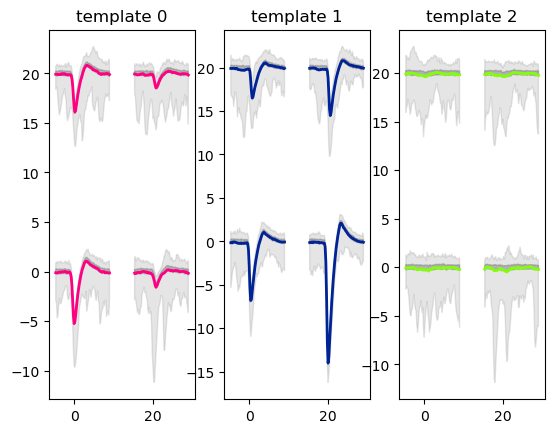

In [4]:
# Note, you can set the number of cores you use using e.g.
# si.set_global_job_kwargs(n_jobs = 8)

"""
# Choose sorting to train the model on
well_id = 'well001'
path_to_sorting = Path(save_root) / well_id / 'sorter_output'
sorting_train = si.read_kilosort(folder_path=path_to_sorting)

# Real Recording Loading
h5 = h5py.File(path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec_train = si.MaxwellRecordingExtractor(path, stream_id=well_id, rec_name=rec_name)
"""

# For testing purposes
rec_train, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=1, num_units=20)
_, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=2, num_units=20)

sorting_train = si.aggregate_units([sorting_1, sorting_2])


analyzer = si.create_sorting_analyzer(sorting=sorting_train, recording=rec_train)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates'])
si.plot_unit_templates(analyzer, unit_ids=["0", "1", "2"])

analyzer.compute(['spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])

#labels = pd.read_csv(path_to_sorting / 'cluster_KSLabel.tsv', sep='\t')
manual_labels = ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
                 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
                 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad',
                 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad']

In [5]:
model_folder = "C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC/models"

trainer = sc.train_model(
    mode="analyzers",
    labels=[manual_labels],
    analyzers=[analyzer],
    folder=model_folder,
    overwrite=True, # Set to True if you want to overwrite existing models
    metric_names = None, # Specify which metrics to use for training: by default uses those already calculted
    imputation_strategies = ["median"], # Defaults to all
    scaling_techniques = ["standard_scaler"], # Defaults to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier","LogisticRegression","MLPClassifier"]
    search_kwargs = {'cv': 3} # Parameters used during the model hyperparameter search
)

best_model = trainer.best_pipeline

accuracies = pd.read_csv(Path(model_folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

Running RandomForestClassifier with imputation median and scaling StandardScaler()
BayesSearchCV from scikit-optimize not available, using RandomizedSearchCV


,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),1.0,1.0,1.0,0,"{'n_estimators': 150, 'min_samples_split': 2, ..."


   prediction  probability
0        good     1.000000
1        good     1.000000
2        good     0.556778
3        good     1.000000
4         bad     0.591593
5        good     0.715111
6        good     1.000000
7        good     0.984444
8        good     1.000000
9        good     0.844667
10       good     0.948889
11       good     1.000000
12       good     0.983333
13       good     1.000000
14       good     0.893333
15       good     0.993333
16       good     0.990000
17       good     1.000000
18       good     1.000000
19       good     0.993333
20        bad     0.964444
21        bad     0.905148
22        bad     0.919667
23        bad     0.937481
24        bad     0.866333
25        bad     0.941222
26        bad     0.934222
27        bad     0.919000
28        bad     0.842778
29        bad     0.881222
30        bad     0.878148
31        bad     0.815222
32        bad     0.978889
33        bad     0.870444
34        bad     0.940889
35        bad     0.921111
3

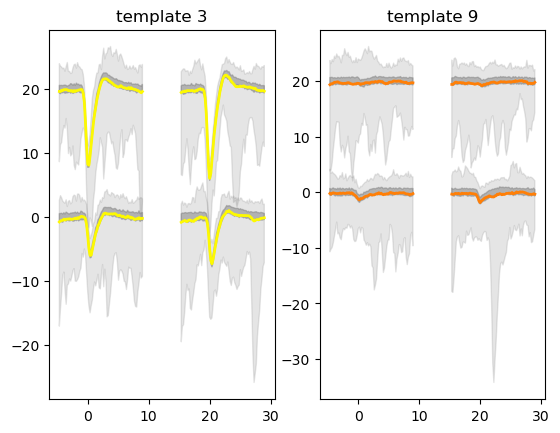

In [6]:
model, model_info = sc.load_model(
    model_folder=model_folder,
    trusted=['numpy.dtype'] # Specify which modules are trusted
)

labels_and_probababilities = si.auto_label_units(
    sorting_analyzer=analyzer,
    model_folder=model_folder,
    trust_model=True
)

""" 
# We can load a pretrained model from HuggingFace instead of training one
model, model_info = sc.load_model(
    sorting_analyzer = analyzer,
    repo_id = "SpikeInterface/toy_tetrode_model",
    trusted = ['numpy.dtype']
)


# The returned labels and probabilities are stored in the sorting analyzer
labels = analyzer.sorting.get_property("classifier_label")
probabilities = analyzer.sorting.get_property("classifier_probability")
"""

print(labels_and_probababilities)

sw.plot_unit_templates(analyzer, unit_ids=['3','9'])


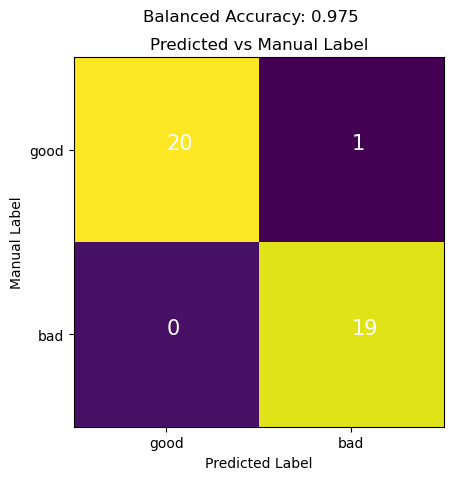

In [7]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

label_conversion = model_info['label_conversion']
predictions = labels_and_probababilities['prediction']

conf_matrix = confusion_matrix(manual_labels, predictions)

# Calculate balanced accuracy for the confusion matrix
balanced_accuracy = balanced_accuracy_score(manual_labels, predictions)

plt.imshow(conf_matrix)
for (index, value) in np.ndenumerate(conf_matrix):
    plt.annotate( str(value), xy=index, color="white", fontsize="15")
plt.xlabel('Predicted Label')
plt.ylabel('Manual Label')
plt.xticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.yticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.title('Predicted vs Manual Label')
plt.suptitle(f"Balanced Accuracy: {balanced_accuracy}")
plt.show()

### Apply Model

In [ ]:
const = 1

#for stream_id in tqdm(stream_ids):
for i in range(10):
    """
    h5 = h5py.File(path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(path, stream_id=stream_id, rec_name=rec_name)

    path_to_sorting = Path(save_root) / stream_id / 'sorter_output'
    sorting = si.read_kilosort(folder_path=path_to_sorting)
    """

    rec, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=const, num_units=5)
    _, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=const+1, num_units=5)
    const += 2

    sorting = si.aggregate_units([sorting_1, sorting_2])

    analyzer = si.create_sorting_analyzer(sorting=sorting, recording=rec)
    analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components', 'quality_metrics', 'template_metrics'])

    all_metric_names = list(analyzer.get_extension('quality_metrics').get_data().keys()) + list(analyzer.get_extension('template_metrics').get_data().keys())
    print(set(model.feature_names_in_).issubset(set(all_metric_names)))

    labels_and_probababilities = si.auto_label_units(
        sorting_analyzer=analyzer,
        model_folder=model_folder,
        #repo_id="SpikeInterface/UnitRefine_noise_neural_classifier",
        trust_model=True
    )

    labels_and_probababilities = pd.DataFrame(labels_and_probababilities)
    #labels_and_probababilities.to_csv(path_to_sorting / 'labels_and_probabilities.csv')
    labels_and_probababilities.to_csv(f'{i+1}_labels_and_probabilities.csv')

: 